# Network Analysis

Applying network analysis to the outbound and inbound voyages at ports allows for visualisation of the most important routes for Great Britain. 

In [1]:
# base libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import nxviz as nv
import os
import json
%matplotlib inline

In [2]:
import pylab as plt
from networkx.drawing.nx_agraph import graphviz_layout

In [3]:
# set variable from config file
config_path = os.path.abspath('..')

with open(config_path + '/config.json', 'r') as f:
    config = json.load(f)

cers_path = config['DEFAULT']['cers_path']
cers_filename = config['DEFAULT']['cers_filename']
ship_class_path = config['DEFAULT']['ship_class_path']
ship_class_filename = config['DEFAULT']['ship_class_filename']
location_path = config['DEFAULT']['location_path']
location_filename = config['DEFAULT']['location_filename']

In [4]:
# import data
CERS = pd.read_csv(cers_path+cers_filename,header = 0,delimiter = ',')
ship_class = pd.read_csv(ship_class_path+ship_class_filename,header = 0,delimiter = ',')
location = pd.read_csv(location_path+location_filename,header = 0,delimiter = ',',index_col='LOCODE')
location = location.dropna(subset=['lat','long'])

In [5]:
# join the ship type and restrict the data to the chosen ship types
CERS = CERS.merge(ship_class,how='left',on=['MMSI'])
extract_mask = (CERS['Type'] == 'container ship') | (CERS['Type'] == 'general cargo ship') | (CERS['Type'] == 'chemical / oil product tanker') | (CERS['Type'] == 'cargo ship') | (CERS['Type'] == 'bulk carrier')
CERS_clean = CERS[extract_mask].copy(deep = True)

In [6]:
# sum the number of journeys per port combination
voyage1 = CERS_clean.groupby(['last_port_LOCODE','POC_LOCODE'],as_index = False)['voyage_id'].count()
voyage2 = CERS_clean.groupby(['POC_LOCODE','next_port_LOCODE'],as_index = False)['voyage_id'].count()
# rename the columns to the same name
voyage1.rename({'last_port_LOCODE':'port_from','POC_LOCODE':'port_to'},axis=1,inplace=True)
voyage2.rename({'POC_LOCODE':'port_from','next_port_LOCODE':'port_to'},axis=1,inplace=True)
# combine the journeys together whether they are entering or leaving the port
voyage3 = voyage1.append(voyage2)
voyage3 = voyage3.dropna()
# sum the number of journerys per port combination
voyage4 = voyage3.groupby(['port_from','port_to'],as_index=False)['voyage_id'].sum()

## Country Networks

In order to produce more meaningful results ports outside Great Britain are aggregated to a country level

In [7]:
def port_code_for_country(x):
    ''' 
    Reduces strings not beginning with 'GB' to the first two characters
    Parameters
      x: a string 
    Returns a string 
    '''
    if x[:2] == 'GB':
        return x
    else:
        return x[:2]

In [8]:
voyage4['port_from2'] = voyage4.apply(lambda row: port_code_for_country(row['port_from']),axis=1)
voyage4['port_to2'] = voyage4.apply(lambda row: port_code_for_country(row['port_to']),axis=1)

In [9]:
# aggregate voyages involving other countries to the total country level
voyage_country = voyage4.groupby(['port_from2','port_to2'],as_index=False)['voyage_id'].sum()

### Network using voyages with at least one UK port

In [10]:
# creating a port_to and port_from using country codes only including GB
voyage4['portc_from'] = voyage4['port_from'].str[:2]
voyage4['portc_to'] = voyage4['port_to'].str[:2]

In [11]:
# aggregating voyages to GB level
voyage_country_only = voyage4.groupby(['portc_from','portc_to'],as_index=False)['voyage_id'].sum()

In [12]:
# for ease of visualisation only plotting port combinations with at least 10 journeys
voyage_country_only = voyage_country_only[voyage_country_only.voyage_id > 10]

In [13]:
# unique list of all ports in the dataset
locationCa = set(voyage_country_only['portc_from'])
locationCb = set(voyage_country_only['portc_to'])
locationCss = locationCa.union(locationCb)

In [14]:
# removing ports which aren't real countries such as 'ZZCAN' which means cancelled port
location_points = location[location.index != 'OR']
location_points = location_points[location_points.index != 'ZZ']
location_points = location_points[location_points.index != 'XZ']
location_points = location_points[location_points.index != 'ZZCAN']
# remove the individual ports in the UK and add one pair of lat/longs for the UK
location_points = location_points[location_points.index.str[:2] != 'GB']
location_points.loc['GB'] = ['Great Britain',np.nan,np.nan, 53.71,-2.07,]

In [15]:
# only keep the countries with a lat and long
locationCss = [l for l in locationCss if l in list(location_points.index)]

### Plot requirements

In [16]:
# exclusion list for ports outside the 3,500km distance from GB
exclusion_list = ['US','RU','SG','TZ','LK','MY']

In [17]:
def plot_network(location, nodes, edges, weights):
    num_edges = len(edges)
    for i in range(num_edges):
        
        j=(i+1)%num_edges
        
        loc_i = edges[i][0]
        loc_j = edges[i][1]
        
        if loc_i not in exclusion_list and loc_j not in exclusion_list:
            
            y1 = location.loc[loc_i,['lat']]
            x1 = location.loc[loc_i,['long']]
            y2 = location.loc[loc_j,['lat']]
            x2 = location.loc[loc_j,['long']]

            plt.plot((x1,x2), (y1,y2), linestyle = '-', c = weight_colours[i], linewidth = round(((weights[i] - np.min(weights))/(np.max(weights)-np.min(weights)))*5,1)+0.5) 

    for i in nodes:
        if i not in exclusion_list:
            y = location.loc[i,['lat']]
            x = location.loc[i,['long']]
            name = location.loc[i,['name']][0]
            plt.annotate(name, (x,y))

def plot_central(location, port_rank):   
    for i in port_rank:
        if i not in exclusion_list:
            y = location.loc[i,['lat']]
            x = location.loc[i,['long']]
            if i == 'GB':
                plt.scatter(x, y, color = 'blue', marker = 'o')
            else:
                plt.scatter(x, y, color = 'green', marker = 'o')

### Voyages from Great Britain to countries within 3,500km

In [18]:
if 'GCssE' in locals():
    del GCssE

# create the network
GCssE = nx.DiGraph()
    
# add ports as nodes to the network
for i in locationCss:
    GCssE.add_node(i, pos = (location_points.loc[i,['lat']], location_points.loc[i,['long']]))
    
# add voyages as edges to the network
for i, row in voyage_country_only.iterrows():
    if row.portc_from in locationCss and row.portc_to in locationCss and row.portc_from[:2] == 'GB':
        GCssE.add_edge(row.portc_from, row.portc_to, weight = row.voyage_id)

In [19]:
edges = list(GCssE.edges())
nodes = GCssE.nodes()
weights = list(nx.get_edge_attributes(GCssE,'weight').values())

port_rank = dict(nx.degree_centrality(GCssE).items())

In [20]:
weight_colours = []
for l in weights:
    if l > 1000:
        weight_colours.append('red')
    elif l > 500:
        weight_colours.append('orange')
    else:
        weight_colours.append('grey')

The network shows the voyages from GB to countries within 3,500km, highlighting the Netherlands, Belgium and Germany as the most important neighbours. 

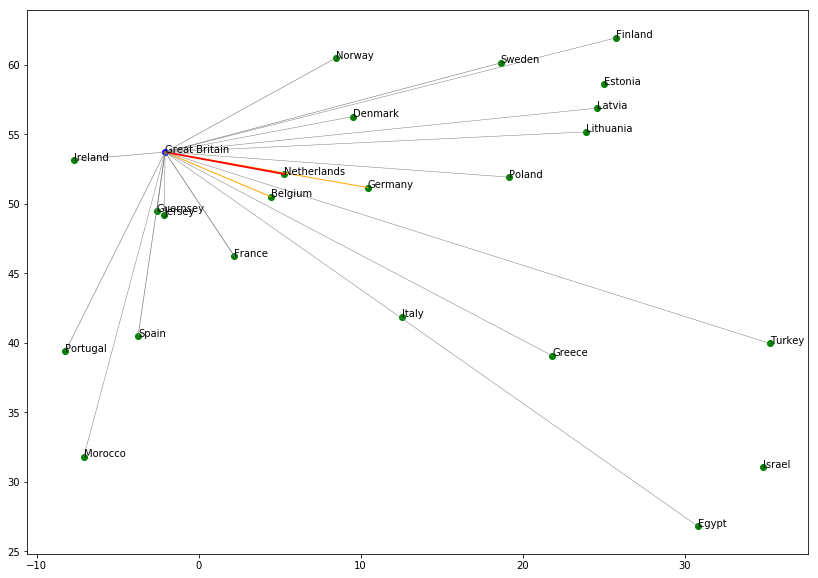

In [21]:
f,ax = plt.subplots(figsize=(14,10)) 
plot_network(location_points, nodes, edges, weights)
plot_central(location_points, port_rank)

### Voyages to Great Britain from countries within 3,500km

In [22]:
if 'GCssI' in locals():
    del GCssI

# create the network
GCssI = nx.DiGraph()
    
# add the ports as nodes to the network
for i in locationCss:
    GCssI.add_node(i, pos = (location_points.loc[i,['lat']], location_points.loc[i,['long']]))
    
# add voyages as edges to the network
for i, row in voyage_country_only.iterrows():
    if row.portc_from in locationCss and row.portc_to in locationCss and row.portc_to[:2] == 'GB':
        GCssI.add_edge(row.portc_from, row.portc_to, weight = row.voyage_id)

In [23]:
edges = list(GCssI.edges())
nodes = GCssI.nodes()
weights = list(nx.get_edge_attributes(GCssI,'weight').values())

port_rank = dict(nx.degree_centrality(GCssI).items())

In [24]:
weight_colours = []
for l in weights:
    if l > 1000:
        weight_colours.append('red')
    elif l > 500:
        weight_colours.append('orange')
    else:
        weight_colours.append('grey')

The second network shows the voyages to GB from countries within 3,500km, also highlighting the Netherlands, Belgium and Germany as the most important neighbours plus Spain. 37% of all inbound and outbound voyages are between ports within the Great Britain, with 19% between GB and the Netherlands, 8% between Belgium and GB and 7% between Germany and GB.

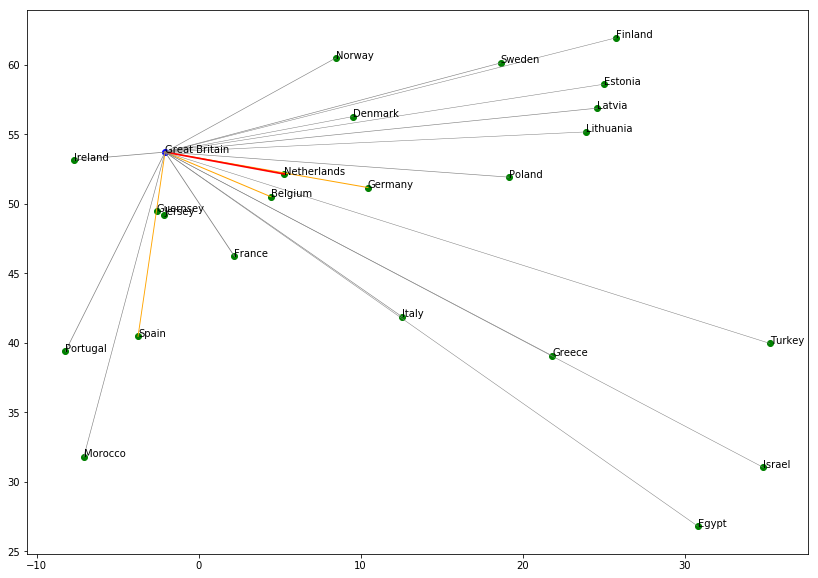

In [25]:
f,ax = plt.subplots(figsize=(14,10)) 
plot_network(location_points, nodes, edges, weights)
plot_central(location_points, port_rank)

### Voyages from countries within 3,500km in and out of Felixstowe

In [26]:
Felixstowe_voyages = voyage4[(voyage4['port_from2'] == 'GBFXT') | (voyage4['port_to2'] == 'GBFXT')]

In [27]:
# for ease of visualisation only plotting port combinations with at least 10 journeys
FelixstoweSS = Felixstowe_voyages[Felixstowe_voyages.voyage_id >= 10]

In [28]:
From_felixstowe = FelixstoweSS[FelixstoweSS.port_from2 == 'GBFXT'].copy()
To_felixstowe = FelixstoweSS[FelixstoweSS.port_from2 != 'GBFXT'].copy()

In [29]:
# due to the way edges are added to the network when a voyage in the opposite direction is added it overwrites the
# original one. Creating new port_from and port_to fields with Felixstowe always the port_from
To_felixstowe['port_from3'] = To_felixstowe['port_to2']
To_felixstowe['port_to3'] = To_felixstowe['port_from2']
From_felixstowe['port_from3'] = From_felixstowe['port_from2']
From_felixstowe['port_to3'] = From_felixstowe['port_to2']

FelixstoweSS = To_felixstowe.append(From_felixstowe)

In [30]:
# aggregate including voyages in and out of Felixstowe
FelixstoweSSg = FelixstoweSS.groupby(['port_from3','port_to3'],as_index=False)['voyage_id'].sum()

In [31]:
# create a unique list of all ports in the dataset
FelixstoweUKa = set(FelixstoweSSg['port_from3'])
FelixstoweUKb = set(FelixstoweSSg['port_to3'])
FelixstoweUKc = FelixstoweUKa.union(FelixstoweUKb)

In [32]:
# create the network
if 'GFss' in locals():
    del GFss

GFss = nx.DiGraph()
    
# add the ports as nodes to the network    
for i in FelixstoweUKc:
    GFss.add_node(i, pos = (location.loc[i,['lat']], location.loc[i,['long']]))
    
# add the voyages as edges to the network
for i, row in FelixstoweSSg.iterrows():
    if row.port_from3 in FelixstoweUKc and row.port_to3 in FelixstoweUKc:
        GFss.add_edge(row.port_from3, row.port_to3, weight = row.voyage_id)

In [33]:
edges = list(GFss.edges())
nodes = GFss.nodes()
weights = list(nx.get_edge_attributes(GFss,'weight').values())
port_rank = dict(nx.degree_centrality(GFss).items())

In [34]:
weight_colours = []
for l in weights:
    if l > 300:
        weight_colours.append('red')
    elif l > 100:
        weight_colours.append('orange')
    else:
        weight_colours.append('grey')

Focusing on Felixstowe emphasises the importance of Felixstowe as a port to Great Britain, with Felixstowe’s most important neighbours aligning with those for Great Britain. 25% of all Felixstowe voyages are between Felixstowe and the Netherlands, 17% between Germany and Felixstowe and 10% between Belgium and Felixstowe.

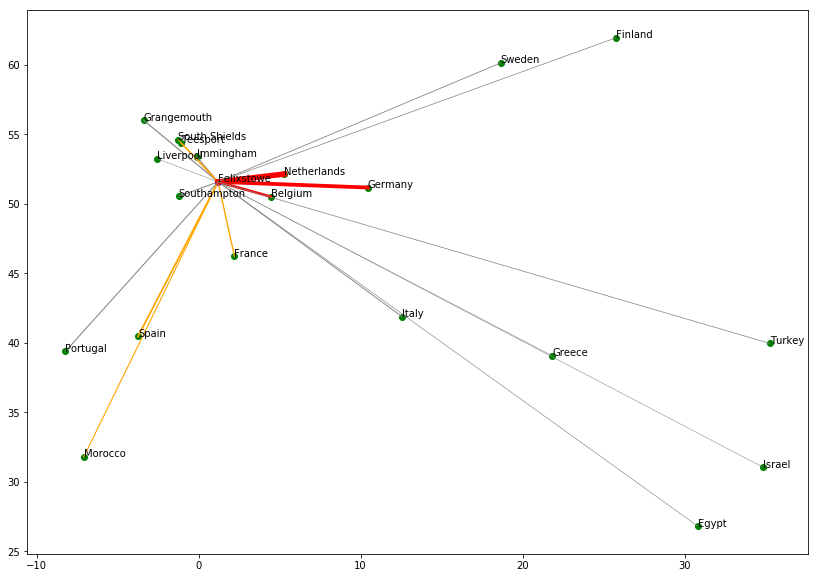

In [35]:
f,ax = plt.subplots(figsize=(14,10)) 
num_edges = len(edges)
for i in range(num_edges):
        
    j=(i+1)%num_edges

    loc_i = edges[i][0]
    loc_j = edges[i][1]

    if loc_i not in exclusion_list and loc_j not in exclusion_list:

        y1 = location.loc[loc_i,['lat']]
        x1 = location.loc[loc_i,['long']]
        y2 = location.loc[loc_j,['lat']]
        x2 = location.loc[loc_j,['long']]

        plt.plot((x1,x2), (y1,y2), linestyle = '-', c = weight_colours[i], linewidth = round(((weights[i] - np.min(weights))/(np.max(weights)-np.min(weights)))*5,1)+0.5) 

for i in nodes:
    if i not in exclusion_list:
        y = location.loc[i,['lat']]
        x = location.loc[i,['long']]
        name = location.loc[i,['name']][0]
        plt.annotate(name, (x,y))

for i in port_rank:
        if i not in exclusion_list:
            y = location.loc[i,['lat']]
            x = location.loc[i,['long']]
            if i == 'GBFXT':
                plt.scatter(x, y, color = 'blue', marker = 'o')
            else:
                plt.scatter(x, y, color = 'green', marker = 'o')